# Processing video with image processing operators

In this tutorial we will see several examples of processing video with image processing operators.

We will focus on how to use the [per_frame](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.per_frame.html) operator to specify temporal arguments, i.e. control arguments for each frame of the processed video. We will load the video as batches of sequences of frames (batches with `FHWC` sample [layout](../../../../data_types.html#data-layouts)) with the [readers.VideoResize](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.readers.VideoResize.html) operator.

Let us start by defining some utilities to display the results.

In [1]:
import base64
import io
import math
import os
from pathlib import Path

import numpy as np
import nvidia.dali.experimental.dynamic as ndd
from IPython import display
from PIL import Image, ImageDraw


def draw_points(images, points):
    assert len(points) == len(images)
    for frame_points, image in zip(points, images):
        draw = ImageDraw.Draw(image)
        for x, y in frame_points:
            draw.ellipse(
                (x - 3, y - 3, x + 3, y + 3), fill="blue", outline="blue"
            )


def display_video(batch: ndd.Batch, duration=50, points=None):
    numpy_batch = np.asarray(ndd.as_tensor(batch.cpu()))
    images = [
        Image.fromarray(np.asarray(frame))
        for sequence in numpy_batch
        for frame in sequence
    ]
    if points is not None:
        numpy_points = np.asarray(ndd.as_tensor(points.cpu()))
        points = [
            frame_points
            for sequence in numpy_points
            for frame_points in sequence
        ]
        draw_points(images, points)
    image, *images = images
    with io.BytesIO() as file:
        image.save(
            file,
            save_all=True,
            append_images=images,
            duration=duration,
            loop=0,
            format="webp",
            minimize_size=True,
        )
        video_data = file.getvalue()
        b64_data = base64.b64encode(video_data).decode("ascii")
        html_tag = f"""
        <style>
        div.nboutput div.output_area.rendered_html {{
            background: transparent !important;
            padding: 0 !important;
            display: inline-block !important;
        }}
        </style>
        <img src="data:image/webp;base64,{b64_data}" 
             alt="Video animation" 
             style="display: block; margin: 0; padding: 0;" />
        """
        display.display(display.HTML(html_tag))

We set the `DALI_EXTRA_PATH` to point to [DALI extra repository](https://github.com/NVIDIA/DALI_extra) with the *Sintel* movie trailer that we will use in the examples.

In [2]:
num_frames, num_channels = 30, 3
# ROI to crop from the video (in H, W coordinates)
roi_start = (90, 0)
roi_end = (630, 1280)

dali_extra_path = Path(os.environ["DALI_EXTRA_PATH"])
vid_dir = dali_extra_path / "db" / "video" / "sintel" / "video_files"
vid_files = ["sintel_trailer-720p_3.mp4"]
vid_filenames = [str(vid_dir / vid_file) for vid_file in vid_files]

Let us read and [rotate](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.rotate.html) video by an angle.

We use `num_frames=30` and `batch_size=4`, which means a single batch consists of 120 frames total, grouped into 4 sequences. Each of the 4 sequences will be rotated by a different angle.


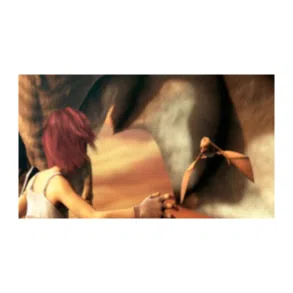

In [3]:
batch_size = 4
size = (144, 256)
diag = math.hypot(*size)

reader = reader = ndd.readers.VideoResize(
    filenames=vid_filenames,
    sequence_length=num_frames,
    file_list_include_preceding_frame=True,
    device="gpu",
    seed=42,
    max_batch_size=batch_size,
)
videos = reader(
    batch_size=batch_size, roi_start=roi_start, roi_end=roi_end, size=size
)
angles = ndd.batch(range(videos.batch_size)) * -10
rotated = ndd.rotate(videos, angle=angles, size=[diag, diag], fill_value=255)

display_video(rotated)

In the presented example, we can see that subsequent fragments of the video are rotated by a different angle.

However, when processing video you may need a finer control over parameters. For example, in the rotation case, you may need to specify a different angle for each frame in each sequence. The [per_frame](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.per_frame.html) operator makes it possible.

Instead of a single angle for a given sequence, we provide an array of angles. The size of the array must match the number of frames in the corresponding video sequence. In our case there are always `num_frames=30` frames in any sequence.

We wrap the angle parameter with a [per_frame](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.per_frame.html) call to hint the [rotate](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.rotate.html) operator that it should use the angles on a per-frame basis.

In [4]:
def rotate_per_frame(angles):
    reader = ndd.readers.VideoResize(
        filenames=vid_filenames,
        sequence_length=num_frames,
        file_list_include_preceding_frame=True,
        device="gpu",
        seed=42,
        max_batch_size=batch_size,
    )
    videos = reader(
        batch_size=batch_size, roi_start=roi_start, roi_end=roi_end, size=size
    )
    rotated = ndd.rotate(
        videos, angle=ndd.per_frame(angles), size=[diag, diag], fill_value=255
    )
    return rotated


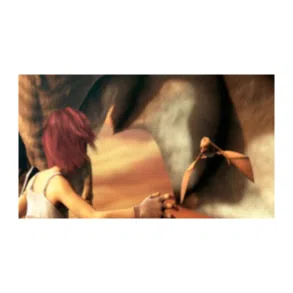

In [5]:
# Angles are defined per sample here and broadcasted in resize
angles = np.linspace(0, -30, num_frames, dtype=np.float32)
video = rotate_per_frame(angles)

display_video(video)

In the presented example, we used a different angle for each frame of the sequence, but the angle vector was the same across different sequences. Let us change that by modifying the angles depending on the sample index in the epoch.


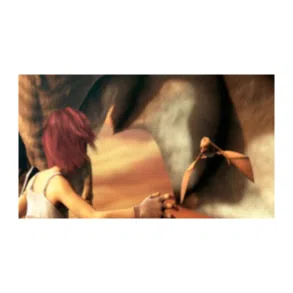

In [6]:
quarter = np.linspace(0, -90, num_frames, endpoint=False, dtype=np.float32)
angles = -90 * ndd.as_batch(np.arange(batch_size)) + quarter
video = rotate_per_frame(angles)

display_video(video)

Now, let us consider a slightly more involved example that combines [warp_affine](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.warp_affine.html) and [gaussian_blur](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.gaussian_blur.html) operators.

The [warp_affine](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.warp_affine.html) will use [per_frame](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.per_frame.html) parameters to apply different transformations to consecutive sequences.
In contrast, the [gaussian_blur](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.gaussian_blur.html) operator will use the same series of parameters for each sequence in the dataset.

In [7]:
size = height, width = 216, 384
max_sigma = 5
batch_size = 8


def compose(*transforms):
    h, *t = transforms
    return h if not t else np.matmul(h, compose(*t))


def translate(offsets):
    return np.array([[[1, 0, tw], [0, 1, th], [0, 0, 1]] for tw, th in offsets])


def scale(scales):
    return np.array([[[sw, 0, 0], [0, sh, 0], [0, 0, 1]] for sw, sh in scales])


def rotate(angles):
    css = [
        (np.cos(angle), np.sin(angle))
        for angle in (math.radians(angle) for angle in angles)
    ]
    return np.array([[[c, -s, 0], [s, c, 0], [0, 0, 1]] for c, s in css])


def rotate_center(angles):
    pre_rot = translate([(-0.5 * width, -0.5 * height)] * len(angles))
    return compose(np.linalg.inv(pre_rot), rotate(angles), pre_rot)


def align_center(sizes):
    return translate([((width - w) / 2, (height - h) / 2) for w, h in sizes])


def move(rs, angles):
    def shift(r, angle):
        dw = r * np.sin(math.radians(angle))
        dh = r * np.cos(math.radians(angle))
        return (dw, dh)

    return translate([shift(r, angle) for r, angle in zip(rs, angles)])


def zoom(start, end):
    scaling = np.linspace(start, end, num_frames)
    s = scale(zip(scaling, scaling))
    t = align_center([(width * s, height * s) for s in scaling])
    return compose(t, s)


def shake():
    max_angle = 30
    angles = (
        np.sin(np.linspace(0, 5 * np.pi, num_frames))
        * max_angle
        * np.linspace(1, 0.25, num_frames)
    )
    return rotate_center(angles)


def circle(r, angle_start, angle_end):
    angles = np.linspace(angle_start, angle_end, num_frames, endpoint=False)
    return compose(move([r] * num_frames, angles), rotate_center(angles - 90))


def warp_matrix(index: int):
    r = height // 3 - 0.125 * height

    if index == 0:
        transform = zoom(1, 0.5)
    elif index == 1:
        transform = compose(zoom(0.5, 0.5), shake())
    elif index == 2:
        move_right = move(np.linspace(0, r, num_frames), [90] * num_frames)
        transform = compose(move_right, zoom(0.5, 0.25))
    elif index == 7:
        move_back = move(np.linspace(r, 0, num_frames), [90] * num_frames)
        transform = compose(move_back, zoom(0.25, 1))
    else:
        # for samples 3, 4, 5, 6
        transform = compose(
            circle(r, 90 * (index - 2), 90 * (index - 1)),
            zoom(0.25, 0.25),
        )

    # Extract 2x3 affine matrix from each 3x3 transform
    return np.array(
        [frame_transform[0:2] for frame_transform in transform],
        dtype=np.float32,
    )


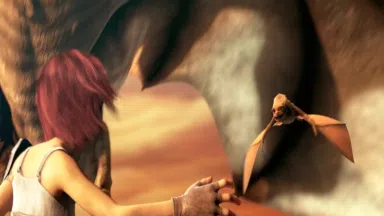

In [8]:
reader = ndd.readers.VideoResize(
    filenames=vid_filenames,
    sequence_length=num_frames,
    file_list_include_preceding_frame=True,
    device="gpu",
    seed=42,
    max_batch_size=batch_size,
)
videos = reader(
    batch_size=batch_size, roi_start=roi_start, roi_end=roi_end, size=size
)
warp_matrices = ndd.as_batch(warp_matrix(index) for index in range(batch_size))
warped = ndd.warp_affine(
    videos,
    ndd.per_frame(warp_matrices),
    fill_value=255,
    inverse_map=False,
    batch_size=batch_size,
)
sigma = np.sin(np.linspace(0, np.pi, num_frames)) * max_sigma
window_size = np.array(2 * np.ceil(sigma) + 1, dtype=np.int32)
blurred = ndd.gaussian_blur(
    warped,
    window_size=ndd.per_frame(window_size),
    sigma=ndd.per_frame(sigma),
)

display_video(blurred)

Computing the transformation matrices by hand may be tiresome. Fortunately DALI comes with a family of [transforms](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.transforms.html) operators that facilitate the task. Let us consider a similar example, but this time using DALI transforms instead of manual matrix computation.

Further, the example will illustrate how to apply the same transforms to a set of keypoints with the [coord_transform](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.coord_transform.html) operator.


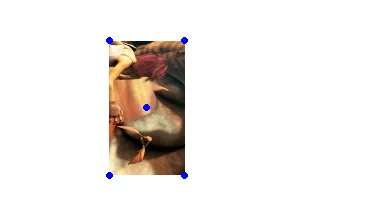

In [9]:
size = height, width = 216, 384
r = height // 3 - 0.125 * height
scale = 0.35

reader = ndd.readers.VideoResize(
    filenames=vid_filenames,
    sequence_length=num_frames,
    file_list_include_preceding_frame=True,
    device="gpu",
    seed=42,
    max_batch_size=batch_size,
)
videos = reader(
    batch_size=batch_size, roi_start=roi_start, roi_end=roi_end, size=size
)

# Shear
shear_angle = 15 * np.sin(
    np.linspace(0, 2 * np.pi, num_frames, endpoint=False),
    dtype=np.float32,
)
shear_angles = ndd.stack(shear_angle, shear_angle, axis=1)
shear = ndd.transforms.shear(
    angles=ndd.per_frame(shear_angles),
    center=[width / 2, height / 2],
)

# Rotation
np_angles = 90 * np.linspace(
    start=1,
    stop=batch_size + 1,
    num=batch_size * num_frames,
    endpoint=False,
    dtype=np.float32,
).reshape(batch_size, -1)
angles_deg = ndd.as_batch(np_angles)
rotation = ndd.transforms.rotation(
    angle=ndd.per_frame(angles_deg), center=[width / 2, height / 2]
)

# Translation
angles_rad = ndd.as_batch(np.deg2rad(np_angles))
shifted_angles = angles_rad + math.pi
shift_s = r * ndd.math.sin(shifted_angles)
shift_c = r * ndd.math.cos(shifted_angles)
move_offset = ndd.stack(shift_s, shift_c, axis=1)
move = ndd.transforms.translation(offset=ndd.per_frame(move_offset))

# Zoom
zoomed_out = ndd.transforms.scale(
    scale=[scale, scale],
    center=[width / 2, height / 2],
)

circle_rotate = ndd.transforms.combine(zoomed_out, shear, rotation, move)

coord = ndd.tensor(
    [
        [0, 0],
        [0, height],
        [width, 0],
        [width, height],
        [width // 2, height // 2],
    ]
)
coord_transformed = ndd.coord_transform(coord, MT=circle_rotate)

# the circle_rotate is already per-frame, wrapping it with per_frame
# call is optional
final_video = ndd.warp_affine(
    videos,
    matrix=circle_rotate,
    fill_value=255,
    inverse_map=False,
)

display_video(final_video, points=coord_transformed)